# Reclassifying Land Cover into Runoff Coefficient Values

## Step 1: Load Required Libraries

In [1]:
import rasterio
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

## Step 2: Load the Land Cover Raster

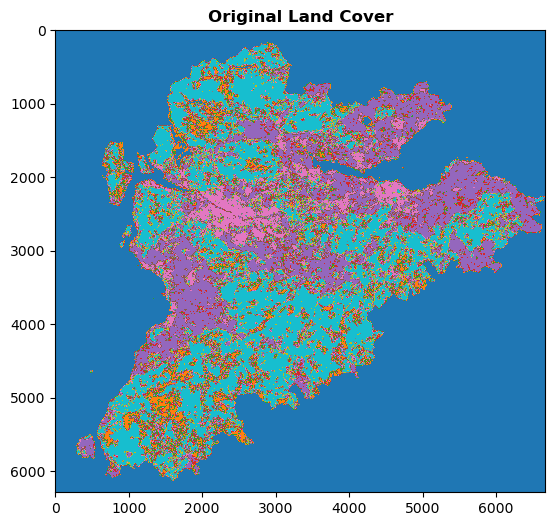

In [2]:
# Specify the path to your land cover raster file
land_cover_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/ESRILandCover_2_Resample.tif"

# Open the raster
with rasterio.open(land_cover_path) as src:
    land_cover = src.read(1)  # Read the first band
    profile = src.profile  # Save the profile for later
    no_data_value = src.nodata  # Get the no-data value if set

# Visualize the land cover raster
plt.figure(figsize=(8, 6))
show(land_cover, cmap='tab10', title="Original Land Cover")
plt.show()

## Step 3: Create a Reclassification Map

In [5]:
# Define the reclassification mapping
reclass_map = {
    1: 1.00,   # Water
    2: 0.15,   # Trees
    11: 0.30,  # Rangeland
    4: 0.80,   # Flooded Vegetation
    5: 0.40,   # Crops
    7: 0.85,   # Built-Up Area
    8: 0.60,   # Bare Ground
    9: 0.60,   # Snow/Ice
    10: np.nan # Clouds, assign no-data (or handle separately later)
}


## Step 4: Reclassify the Raster

In [7]:
# Ensure the array is of float type to allow np.nan values
reclassified = np.full(land_cover.shape, np.nan, dtype='float32')  # Initialize with np.nan

# Apply the reclassification
for lc_value, runoff_value in reclass_map.items():
    reclassified[land_cover == lc_value] = runoff_value

# Handle no-data (if necessary)
if no_data_value is not None:
    reclassified[land_cover == no_data_value] = np.nan  # Assign no-data


## Step 5: Save the Reclassified Raster

In [8]:
# Step 5: Save the reclassified raster
from rasterio import Affine

# Define the metadata for the output raster
out_meta = src.meta.copy()  # Use the original metadata from the input raster
out_meta.update({
    "dtype": "float32",  # Ensure the data type matches the reclassified array
    "nodata": np.nan,    # Define no-data value
})

# Save the reclassified raster
output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/reclassified_runoff_coefficients.tif"
with rasterio.open(output_path, "w", **out_meta) as dst:
    dst.write(reclassified, 1)  # Write the reclassified array to the first band
print(f"Reclassified runoff coefficients saved to {output_path}")


Reclassified runoff coefficients saved to C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/reclassified_runoff_coefficients.tif


## Step 6: Verify the Output

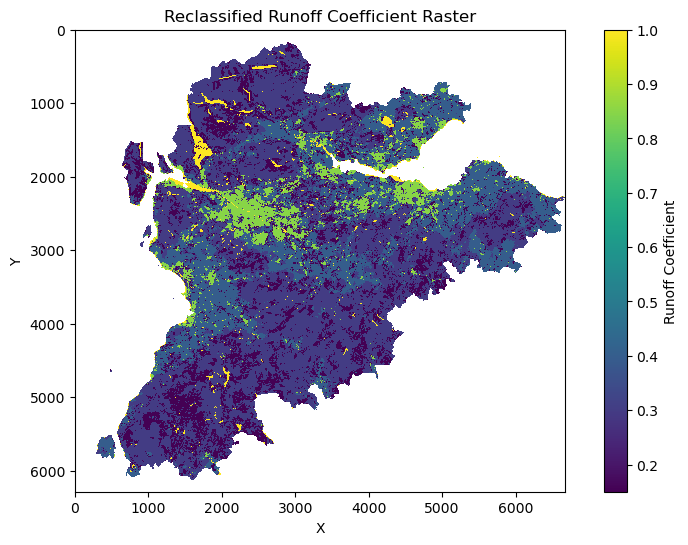

In [9]:
# Step 6: Verify the output by loading and displaying it
import matplotlib.pyplot as plt

# Load the saved raster to check it
with rasterio.open(output_path) as dataset:
    data = dataset.read(1)

# Plot the reclassified raster
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='viridis', interpolation='none')
plt.colorbar(label="Runoff Coefficient")
plt.title("Reclassified Runoff Coefficient Raster")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Step 7: Check No Data Values
### 1. Crop Raster

In [3]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# Load your raster and AOI shapefile
raster_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/reclassified_runoff_coefficients.tif"
aoi_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/StudyArea/Study_Area.shp"
# Load the AOI as a GeoDataFrame
aoi = gpd.read_file(aoi_path)

In [4]:
# Ensure the AOI and raster have the same CRS
with rasterio.open(raster_path) as src:
    if aoi.crs != src.crs:
        aoi = aoi.to_crs(src.crs)

    # Extract the geometry of the AOI polygon
    aoi_geom = [feature["geometry"] for feature in aoi.to_dict("records")]

    # Clip and mask the raster
    cropped_raster, cropped_transform = mask(src, aoi_geom, crop=True)

    # Copy metadata and update for the new raster
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "driver": "GTiff",
        "height": cropped_raster.shape[1],
        "width": cropped_raster.shape[2],
        "transform": cropped_transform
    })

# Save the cropped raster
output_path = "C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/cropped_raster.tif"
with rasterio.open(output_path, "w", **cropped_meta) as dst:
    dst.write(cropped_raster)

print(f"Raster clipped and saved to {output_path}")

Raster clipped and saved to C:/GIS_Course/MScThesis-MaviSantarelli/data/Predictors/RunoffCoefficient/cropped_raster.tif


### 2. Identify No-Data Pixels within AOI

AOI Area: 16624.06 km²
Valid area in AOI: 16623.35 km²
No-data area in AOI: 0.93 km²
Percentage of no-data in AOI: 0.01%


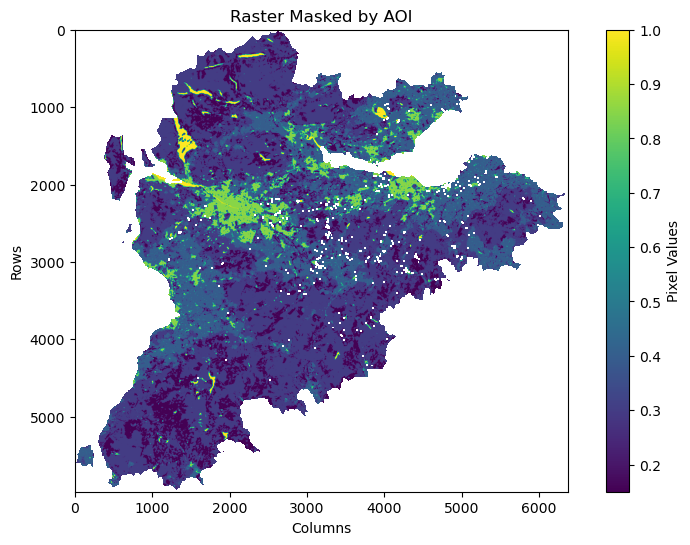

In [8]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

aoi_combined = aoi.unary_union

with rasterio.open(output_path) as src:
    raster_data = src.read(1)  # Read the first band
    raster_meta = src.meta
    raster_crs = src.crs
    pixel_size = src.transform[0]  # Assuming square pixels

    # Ensure AOI CRS matches raster CRS
    if aoi_gdf.crs != raster_crs:
        aoi_gdf = aoi_gdf.to_crs(raster_crs)
        aoi_combined = aoi_gdf.unary_union

    # Rasterize AOI on the same grid as the raster
    aoi_mask = rasterize(
        [(aoi_combined, 1)],  # Value 1 for inside AOI
        out_shape=raster_data.shape,
        transform=src.transform,
        fill=0,
        dtype='uint8'
    )

# Filter pixels inside AOI mask
valid_pixels = np.count_nonzero((aoi_mask == 1) & (~np.isnan(raster_data)))
no_data_pixels = np.count_nonzero((aoi_mask == 1) & (np.isnan(raster_data)))

# Calculate areas
pixel_area_km2 = (pixel_size ** 2) / 1e6  # Convert from square meters to square kilometers
valid_area_km2 = valid_pixels * pixel_area_km2
no_data_area_km2 = no_data_pixels * pixel_area_km2

# Print the results
print(f"AOI Area: {aoi_combined.area / 1e6:.2f} km²")
print(f"Valid area in AOI: {valid_area_km2:.2f} km²")
print(f"No-data area in AOI: {no_data_area_km2:.2f} km²")
print(f"Percentage of no-data in AOI: {(no_data_pixels / (valid_pixels + no_data_pixels)) * 100:.2f}%")

# Plot the masked raster
plt.figure(figsize=(10, 6))
plt.imshow(np.where(aoi_mask == 1, raster_data, np.nan), cmap='viridis', origin='upper')
plt.colorbar(label="Pixel Values")
plt.title("Raster Masked by AOI")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


### 3. Interpolating Using Bilinear Method

Since the no-data area is only 0.01% of the AOI and likely surrounded by valid pixels, interpolation using the bilinear method is recommended. This method will assign values to the no-data pixels based on a weighted average of surrounding values, ensuring a smooth transition.

In [ ]:
from scipy.interpolate import griddata
import time

# Start timing
start_time = time.time()

print("Step 1: Extracting valid pixel coordinates and values...")
# Get coordinates of valid pixels and their values
rows, cols = np.where((aoi_mask == 1) & (~np.isnan(raster_data)))
values = raster_data[rows, cols]
print(f"  - Found {len(values)} valid pixels for interpolation.")

# Create a grid of coordinates for the entire raster
print("Step 2: Creating grid for interpolation...")
grid_x, grid_y = np.meshgrid(np.arange(raster_data.shape[1]), np.arange(raster_data.shape[0]))
print(f"  - Grid shape: {grid_x.shape}")

# Interpolate no-data pixels using bilinear interpolation
print("Step 3: Performing bilinear interpolation...")
interpolated_raster = griddata((cols, rows), values, (grid_x, grid_y), method='linear')

# Fill remaining NaNs using nearest-neighbor interpolation (for edge cases)
print("Step 4: Handling remaining NaNs using nearest-neighbor interpolation...")
interpolated_raster = np.where(np.isnan(interpolated_raster), 
                               griddata((cols, rows), values, (grid_x, grid_y), method='nearest'),
                               interpolated_raster)

print("Step 5: Plotting the interpolated raster...")
# Plot the interpolated raster
plt.figure(figsize=(10, 6))
plt.imshow(interpolated_raster, cmap='viridis', origin='upper')
plt.colorbar(label="Interpolated Runoff Coefficient")
plt.title("Interpolated Runoff Coefficient Raster")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# End timing and print duration
end_time = time.time()
print(f"Interpolation completed in {end_time - start_time:.2f} seconds.")